In [1]:
import mne
import numpy as np
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse, compute_source_psd_epochs, write_inverse_operator
import numpy as np
import matplotlib.pyplot as plt
from hdf5storage import loadmat, savemat 

In [2]:
sample_data_raw_file="./egi_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.load_data()

Opening raw data file ./egi_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 208)  idle
    Range : 0 ... 181999 =      0.000 ...   181.999 secs
Ready.
Reading 0 ... 181999  =      0.000 ...   181.999 secs...


<Raw | egi_raw.fif, 256 x 182000 (182.0 s), ~355.8 MB, data loaded>

In [3]:
data=raw['data'][0]
Fs=1000
nepochs=int(np.floor(np.shape(data)[1]/Fs))

In [4]:
raw.info['bads']

['E241',
 'E242',
 'E243',
 'E238',
 'E239',
 'E240',
 'E244',
 'E245',
 'E246',
 'E247',
 'E251',
 'E256',
 'E91',
 'E102',
 'E111',
 'E120',
 'E133',
 'E145',
 'E165',
 'E174',
 'E187',
 'E199',
 'E208',
 'E216',
 'E229',
 'E233',
 'E237',
 'E236',
 'E235',
 'E234',
 'E232',
 'E228',
 'E217',
 'E209',
 'E200',
 'E188',
 'E175',
 'E166',
 'E156',
 'E146',
 'E134',
 'E121',
 'E112',
 'E103',
 'E92',
 'E82',
 'E255',
 'E250']

In [5]:
# epochs_mat=np.zeros((nepochs,3))
# for r in range(nepochs):
#     epochs_mat[r,:]=np.array([int(r*Fs), int(0), int(1)])

In [6]:
epochs_mat = np.column_stack(
    (
        np.arange(0, np.shape(data)[1], Fs),
        np.zeros(nepochs, dtype=int),
        np.array([1]*nepochs),
    )
)


In [7]:
epochs_mat

array([[     0,      0,      1],
       [  1000,      0,      1],
       [  2000,      0,      1],
       [  3000,      0,      1],
       [  4000,      0,      1],
       [  5000,      0,      1],
       [  6000,      0,      1],
       [  7000,      0,      1],
       [  8000,      0,      1],
       [  9000,      0,      1],
       [ 10000,      0,      1],
       [ 11000,      0,      1],
       [ 12000,      0,      1],
       [ 13000,      0,      1],
       [ 14000,      0,      1],
       [ 15000,      0,      1],
       [ 16000,      0,      1],
       [ 17000,      0,      1],
       [ 18000,      0,      1],
       [ 19000,      0,      1],
       [ 20000,      0,      1],
       [ 21000,      0,      1],
       [ 22000,      0,      1],
       [ 23000,      0,      1],
       [ 24000,      0,      1],
       [ 25000,      0,      1],
       [ 26000,      0,      1],
       [ 27000,      0,      1],
       [ 28000,      0,      1],
       [ 29000,      0,      1],
       [ 3

In [8]:
epoch_dict = dict(resting=1)

epochs = mne.Epochs(raw, epochs_mat, tmin=0, tmax=0.999, event_id=epoch_dict, preload=True, baseline=(None, None))


Not setting metadata
182 matching events found
Setting baseline interval to [0.0, 0.999] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 182 events and 1000 original time points ...
0 bad epochs dropped


In [9]:
evoked = epochs["resting"].average()
mne.write_evokeds('resting_ave.fif', evoked, on_mismatch='raise', overwrite=True, verbose=None)
evokeds = mne.read_evokeds('./resting_ave.fif')
resting = evokeds[0]

Overwriting existing file.
Reading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/goodchanEGI_pipeline/resting_ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 208) active
    Found the data of interest:
        t =       0.00 ...     999.00 ms (resting)
        0 CTF compensation matrices available
        nave = 182 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [0, 0.999] sec)


Using up to 910 segments
Number of samples used : 182000
[done]
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-13 (2.2e-16 eps * 208 dim * 18  max singular value)
    Estimated rank (eeg): 206
    EEG: rank 206 computed from 208 data channels with 0 projectors


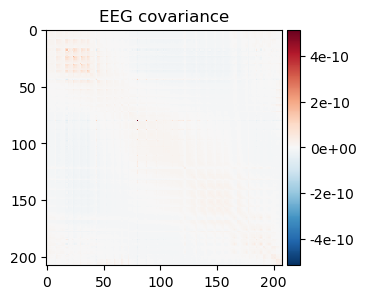

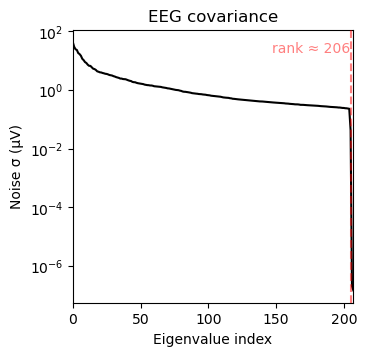

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [10]:
# use the entire data as empty room noise
noise_cov = mne.compute_raw_covariance(raw)
noise_cov.plot(raw.info, proj=True)


In [11]:
noise_cov.keys()

dict_keys(['data', 'dim', 'names', 'bads', 'nfree', 'eig', 'eigvec', 'diag', 'projs', 'kind'])

In [12]:
noise_cov_mat=noise_cov['data']# it only included the good chans


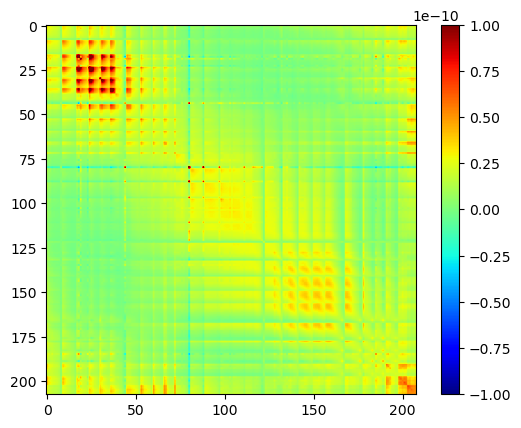

In [13]:
from matplotlib import pyplot as plt
plt.imshow(noise_cov_mat,cmap='jet',vmin=-1e-10,vmax=1e-10); plt.colorbar() 

In [14]:
# compute the average of the diagonal
# construct the scale of the noise cov
scale=0.01 # 1% 5% 10%
scale_ave=np.mean(noise_cov_mat.diagonal())*0.01
sim_cov_mat=np.zeros((np.shape(noise_cov_mat)))
for i in range(np.shape(sim_cov_mat)[0]):
       sim_cov_mat[i,i]=scale_ave


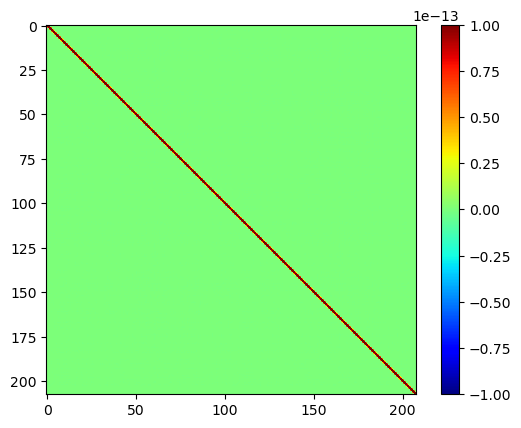

In [15]:
plt.imshow(sim_cov_mat,cmap='jet',vmin=-1e-13,vmax=1e-13); plt.colorbar() 

In [16]:
noise_cov.keys()

dict_keys(['data', 'dim', 'names', 'bads', 'nfree', 'eig', 'eigvec', 'diag', 'projs', 'kind'])

In [17]:
sim_cov=noise_cov.copy()

In [18]:
sim_cov['data']=sim_cov_mat

In [19]:
mne.write_cov('sim_cov.fif', sim_cov, overwrite=True, verbose=None)

Overwriting existing file.


In [20]:
fwd = mne.read_forward_solution('surface_egi_fsaverage_fixed_fwd.fif')
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

Reading forward solution from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/goodchanEGI_pipeline/surface_egi_fsaverage_fixed_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 256 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


Good channels,256 EEG
Bad channels,None
Source space,Surface with 1284 vertices
Source orientation,Free


In [22]:
noise_cov = mne.read_cov('./sim_cov.fif')

    208 x 208 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 208)  idle


In [23]:
# Compute the source estimate (Fixed dipole orientations)
inverse_operator = make_inverse_operator(resting.info, fwd, noise_cov, depth=2, fixed=True)

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 208 channels.
    208 out of 256 channels remain after picking
Selected 208 channels
Creating the depth weighting matrix...
    208 EEG channels
    limit = 1285/1284 = 1.732009
    scale = 425832 exp = 2
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.8e-16 (2.2e-16 eps * 208 dim * 0.004  max singular value)
    Estimated rank (eeg): 207
    EEG: rank 207 computed from 208 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source cov

In [24]:
snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr**2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# define frequencies of interest
fmin, fmax = 0.0, 50.0
bandwidth = 1.0  # bandwidth of the windows in Hz

In [25]:
n_epochs_use = nepochs
stcs = compute_source_psd_epochs(
    epochs[:n_epochs_use],
    inverse_operator,
    lambda2=lambda2,
    method=method,
    fmin=fmin,
    fmax=fmax,
    bandwidth=bandwidth,
    return_generator=True,
    verbose=True,
)


In [26]:
print(stcs)

<generator object _compute_source_psd_epochs at 0x7f8bb7f55000>


In [27]:
# compute average PSD over the the epochs
psd_avg = 0.0
for i, stc in enumerate(stcs):
    psd_avg += stc.data
psd_avg /= n_epochs_use
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg  # overwrite the last epoch's data with the average
# It takes 1m40s

Considering frequencies 0 ... 50 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 207 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 208 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 208 -> 207
Using 1 tapers with bandwidth 1.0 Hz on 182 epochs


/tmp/ipykernel_3041210/618180516.py:3: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  for i, stc in enumerate(stcs):


  0%|          |  : 0/182 [00:00<?,       ?it/s]

Text(0, 0.5, 'Power Spectral Density')

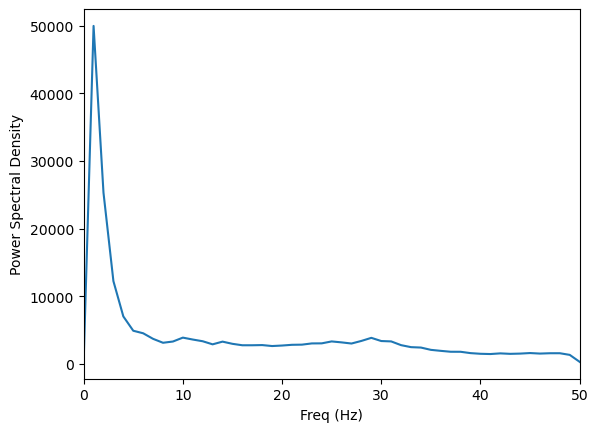

In [28]:
fig, ax = plt.subplots()
ax.plot(freqs, psd_avg.mean(axis=0))
ax.set_xlabel("Freq (Hz)")
ax.set_xlim(stc.times[[0, -1]])
ax.set_ylabel("Power Spectral Density")

In [30]:
from copy import deepcopy

import numpy as np

from mne.minimum_norm.inverse import InverseOperator

from mne.forward.forward import convert_forward_solution, Forward

from mne import pick_channels_forward, EvokedArray
from mne.utils import logger, verbose, _validate_type
from mne.forward.forward import convert_forward_solution, Forward
from mne.io.constants import FIFF
from mne.minimum_norm import apply_inverse
from mne.source_estimate import _prepare_label_extraction, _make_stc, _get_src_type
from mne.source_space import SourceSpaces, _get_vertno
from mne.label import Label

@verbose
def make_inverse_resolution_matrix(
    forward, inverse_operator, method="dSPM", lambda2=1.0 / 9.0, verbose=None
):
    """Compute resolution matrix for linear inverse operator.

    Parameters
    ----------
    forward : instance of Forward
        Forward Operator.
    inverse_operator : instance of InverseOperator
        Inverse operator.
    method : 'MNE' | 'dSPM' | 'sLORETA'
        Inverse method to use (MNE, dSPM, sLORETA).
    lambda2 : float
        The regularisation parameter.
    %(verbose)s

    Returns
    -------
    resmat: array, shape (n_orient_inv * n_dipoles, n_orient_fwd * n_dipoles)
        Resolution matrix (inverse operator times forward operator).
        The result of applying the inverse operator to the forward operator.
        If source orientations are not fixed, all source components will be
        computed (i.e. for n_orient_inv > 1 or n_orient_fwd > 1).
        The columns of the resolution matrix are the point-spread functions
        (PSFs) and the rows are the cross-talk functions (CTFs).
    """
    # make sure forward and inverse operator match
    inv = inverse_operator
    fwd = _convert_forward_match_inv(forward, inv)

    # don't include bad channels
    # only use good channels from inverse operator
    bads_inv = inv["info"]["bads"]
    # good channels
    ch_names = [c for c in inv["info"]["ch_names"] if (c not in bads_inv)]
    fwd = pick_channels_forward(fwd, ch_names, ordered=True)

    # get leadfield matrix from forward solution
    leadfield = fwd["sol"]["data"]
    invmat = _get_matrix_from_inverse_operator(inv, fwd, method=method, lambda2=lambda2)
    resmat = invmat.dot(leadfield)
    logger.info("Dimensions of resolution matrix: %d by %d." % resmat.shape)
    return resmat


@verbose
def _get_psf_ctf(
    resmat,
    src,
    idx,
    *,
    func,
    mode,
    n_comp,
    norm,
    return_pca_vars,
    vector=False,
    verbose=None
):
    """Get point-spread (PSFs) or cross-talk (CTFs) functions."""
    # check for consistencies in input parameters
    _check_get_psf_ctf_params(mode, n_comp, return_pca_vars)

    # backward compatibility
    if norm is True:
        norm = "max"

    # get relevant vertices in source space
    src_orig = src
    _validate_type(src_orig, (InverseOperator, Forward, SourceSpaces), "src")
    if not isinstance(src, SourceSpaces):
        src = src["src"]
    verts_all = _vertices_for_get_psf_ctf(idx, src)
    vertno = _get_vertno(src)
    n_verts = sum(len(v) for v in vertno)
    src_type = _get_src_type(src, vertno)
    subject = src._subject
    if vector and src_type == "surface":
        _validate_type(
            src_orig,
            (Forward, InverseOperator),
            "src",
            extra="when creating a vector surface source estimate",
        )
        nn = src_orig["source_nn"]
    else:
        nn = np.repeat(np.eye(3, 3)[np.newaxis], n_verts, 0)

    n_r, n_c = resmat.shape
    if ((n_verts != n_r) and (n_r / 3 != n_verts)) or (
        (n_verts != n_c) and (n_c / 3 != n_verts)
    ):
        msg = (
            "Number of vertices (%d) and corresponding dimension of"
            "resolution matrix (%d, %d) do not match" % (n_verts, n_r, n_c)
        )
        raise ValueError(msg)

    # the following will operate on columns of funcs
    if func == "ctf":
        resmat = resmat.T
        n_r, n_c = n_c, n_r

    # Functions and variances per label
    stcs = []
    pca_vars = []

    # if 3 orientations per vertex, redefine indices to columns of resolution
    # matrix
    if n_verts != n_c:
        # change indices to three indices per vertex
        for [i, verts] in enumerate(verts_all):
            verts_vec = np.empty(3 * len(verts), dtype=int)
            for [j, v] in enumerate(verts):
                verts_vec[3 * j : 3 * j + 3] = 3 * verts[j] + np.array([0, 1, 2])
            verts_all[i] = verts_vec  # use these as indices

    for verts in verts_all:
        # get relevant PSFs or CTFs for specified vertices
        if type(verts) is int:
            verts = [verts]  # to keep array dimensions
        funcs = resmat[:, verts]

        # normalise PSFs/CTFs if requested
        if norm is not None:
            funcs = _normalise_psf_ctf(funcs, norm)

        # summarise PSFs/CTFs across vertices if requested
        pca_var = None  # variances computed only if return_pca_vars=True
        if mode is not None:
            funcs, pca_var = _summarise_psf_ctf(
                funcs, mode, n_comp, return_pca_vars, nn
            )

        if not vector:  # if one value per vertex requested
            if n_verts != n_r:  # if 3 orientations per vertex, combine
                funcs_int = np.empty([int(n_r / 3), funcs.shape[1]])
                for i in np.arange(0, n_verts):
                    funcs_vert = funcs[3 * i : 3 * i + 3, :]
                    funcs_int[i, :] = np.sqrt((funcs_vert**2).sum(axis=0))
                funcs = funcs_int

        stc = _make_stc(
            funcs,
            vertno,
            src_type,
            tmin=0.0,
            tstep=1.0,
            subject=subject,
            vector=vector,
            source_nn=nn,
        )
        stcs.append(stc)
        pca_vars.append(pca_var)

    # if just one list or label specified, simplify output
    if len(stcs) == 1:
        stcs = stc
    if len(pca_vars) == 1:
        pca_vars = pca_var
    if pca_var is not None:
        return stcs, pca_vars
    else:
        return stcs


def _check_get_psf_ctf_params(mode, n_comp, return_pca_vars):
    """Check input parameters of _get_psf_ctf() for consistency."""
    if mode in [None, "sum", "mean"] and n_comp > 1:
        msg = "n_comp must be 1 for mode=%s." % mode
        raise ValueError(msg)
    if mode != "pca" and return_pca_vars:
        msg = "SVD variances can only be returned if mode=" "pca" "."
        raise ValueError(msg)


def _vertices_for_get_psf_ctf(idx, src):
    """Get vertices in source space for PSFs/CTFs in _get_psf_ctf()."""
    # idx must be list
    # if label(s) specified get the indices, otherwise just carry on
    if type(idx[0]) is Label:
        # specify without source time courses, gets indices per label
        verts_labs, _ = _prepare_label_extraction(
            stc=None,
            labels=idx,
            src=src,
            mode="mean",
            allow_empty=False,
            use_sparse=False,
        )
        # verts_labs can be list of lists
        # concatenate indices per label across hemispheres
        # one list item per label
        verts = []

        for v in verts_labs:
            # if two hemispheres present
            if type(v) is list:
                # indices for both hemispheres in one list
                this_verts = np.concatenate((v[0], v[1]))
            else:
                this_verts = np.array(v)
            verts.append(this_verts)
    # check if list of list or just list
    else:
        if isinstance(idx[0], list):  # if list of list of integers
            verts = idx
        else:  # if list of integers
            verts = [idx]

    return verts


def _normalise_psf_ctf(funcs, norm):
    """Normalise PSFs/CTFs in _get_psf_ctf()."""
    # normalise PSFs/CTFs if specified
    if norm == "max":
        maxval = max(-funcs.min(), funcs.max())
        funcs = funcs / maxval
    elif norm == "norm":  # normalise to maximum norm across columns
        norms = np.linalg.norm(funcs, axis=0)
        funcs = funcs / norms.max()

    return funcs


def _summarise_psf_ctf(funcs, mode, n_comp, return_pca_vars, nn):
    """Summarise PSFs/CTFs across vertices."""
    s_var = None  # only computed for return_pca_vars=True

    if mode == "maxval":  # pick PSF/CTF with maximum absolute value
        absvals = np.maximum(-np.min(funcs, axis=0), np.max(funcs, axis=0))
        if n_comp > 1:  # only keep requested number of sorted PSFs/CTFs
            sortidx = np.argsort(absvals)
            maxidx = sortidx[-n_comp:]
        else:  # faster if only one required
            maxidx = [absvals.argmax()]
        funcs = funcs[:, maxidx]

    elif mode == "maxnorm":  # pick PSF/CTF with maximum norm
        norms = np.linalg.norm(funcs, axis=0)
        if n_comp > 1:  # only keep requested number of sorted PSFs/CTFs
            sortidx = np.argsort(norms)
            maxidx = sortidx[-n_comp:]
        else:  # faster if only one required
            maxidx = [norms.argmax()]
        funcs = funcs[:, maxidx]

    elif mode == "sum":  # sum across PSFs/CTFs
        funcs = np.sum(funcs, axis=1, keepdims=True)

    elif mode == "mean":  # mean of PSFs/CTFs
        funcs = np.mean(funcs, axis=1, keepdims=True)

    elif mode == "pca":  # SVD across PSFs/CTFs
        # compute SVD of PSFs/CTFs across vertices
        u, s, _ = np.linalg.svd(funcs, full_matrices=False, compute_uv=True)
        if n_comp > 1:
            funcs = u[:, :n_comp]
        else:
            funcs = u[:, 0, np.newaxis]
        # if explained variances for SVD components requested
        if return_pca_vars:
            # explained variance of individual SVD components
            s2 = s * s
            s_var = 100 * s2[:n_comp] / s2.sum()

    return funcs, s_var


@verbose
def get_point_spread(
    resmat,
    src,
    idx,
    mode=None,
    *,
    n_comp=1,
    norm=False,
    return_pca_vars=False,
    vector=False,
    verbose=None
):
    """Get point-spread (PSFs) functions for vertices.

    Parameters
    ----------
    resmat : array, shape (n_dipoles, n_dipoles)
        Forward Operator.
    src : instance of SourceSpaces | instance of InverseOperator | instance of Forward
        Source space used to compute resolution matrix.
        Must be an InverseOperator if ``vector=True`` and a surface
        source space is used.
    %(idx_pctf)s
    %(mode_pctf)s
    %(n_comp_pctf_n)s
    %(norm_pctf)s
    %(return_pca_vars_pctf)s
    %(vector_pctf)s
    %(verbose)s

    Returns
    -------
    %(stcs_pctf)s
    %(pca_vars_pctf)s
    """  # noqa: E501
    return _get_psf_ctf(
        resmat,
        src,
        idx,
        func="psf",
        mode=mode,
        n_comp=n_comp,
        norm=norm,
        return_pca_vars=return_pca_vars,
        vector=vector,
    )


@verbose
def get_cross_talk(
    resmat,
    src,
    idx,
    mode=None,
    *,
    n_comp=1,
    norm=False,
    return_pca_vars=False,
    vector=False,
    verbose=None
):
    """Get cross-talk (CTFs) function for vertices.

    Parameters
    ----------
    resmat : array, shape (n_dipoles, n_dipoles)
        Forward Operator.
    src : instance of SourceSpaces | instance of InverseOperator | instance of Forward
        Source space used to compute resolution matrix.
        Must be an InverseOperator if ``vector=True`` and a surface
        source space is used.
    %(idx_pctf)s
    %(mode_pctf)s
    %(n_comp_pctf_n)s
    %(norm_pctf)s
    %(return_pca_vars_pctf)s
    %(vector_pctf)s
    %(verbose)s

    Returns
    -------
    %(stcs_pctf)s
    %(pca_vars_pctf)s
    """  # noqa: E501
    return _get_psf_ctf(
        resmat,
        src,
        idx,
        func="ctf",
        mode=mode,
        n_comp=n_comp,
        norm=norm,
        return_pca_vars=return_pca_vars,
        vector=vector,
    )


def _convert_forward_match_inv(fwd, inv):
    """Ensure forward and inverse operators match.

    Inverse operator and forward operator must have same surface orientations,
    but can have different source orientation constraints.
    """
    _validate_type(fwd, Forward, "fwd")
    _validate_type(inv, InverseOperator, "inverse_operator")
    # did inverse operator use fixed orientation?
    is_fixed_inv = _check_fixed_ori(inv)
    # did forward operator use fixed orientation?
    is_fixed_fwd = _check_fixed_ori(fwd)

    # if inv or fwd fixed: do nothing
    # if inv loose: surf_ori must be True
    # if inv free: surf_ori must be False
    if not is_fixed_inv and not is_fixed_fwd:
        inv_surf_ori = inv._is_surf_ori
        if inv_surf_ori != fwd["surf_ori"]:
            fwd = convert_forward_solution(
                fwd, surf_ori=inv_surf_ori, force_fixed=False
            )

    return fwd


def _prepare_info(inverse_operator):
    """Get a usable dict."""
    # in order to convert sub-leadfield matrix to evoked data type (pretending
    # it's an epoch, see in loop below), uses 'info' from inverse solution
    # because this has all the correct projector information
    info = deepcopy(inverse_operator["info"])
    with info._unlock():
        info["sfreq"] = 1000.0  # necessary
        info["projs"] = inverse_operator["projs"]
        info["custom_ref_applied"] = False
    return info


def _get_matrix_from_inverse_operator(
    inverse_operator, forward, method="dSPM", lambda2=1.0 / 9.0
):
    """Get inverse matrix from an inverse operator.

    Currently works only for fixed/loose orientation constraints
    For loose orientation constraint, the CTFs are computed for the normal
    component (pick_ori='normal').

    Parameters
    ----------
    inverse_operator : instance of InverseOperator
        The inverse operator.
    forward : instance of Forward
        The forward operator.
    method : 'MNE' | 'dSPM' | 'sLORETA'
        Inverse methods (for apply_inverse).
    lambda2 : float
        The regularization parameter (for apply_inverse).

    Returns
    -------
    invmat : array, shape (n_dipoles, n_channels)
        Inverse matrix associated with inverse operator and specified
        parameters.
    """
    # make sure forward and inverse operators match with respect to
    # surface orientation
    _convert_forward_match_inv(forward, inverse_operator)

    info_inv = _prepare_info(inverse_operator)

    # only use channels that are good for inverse operator and forward sol
    ch_names_inv = info_inv["ch_names"]
    n_chs_inv = len(ch_names_inv)
    bads_inv = inverse_operator["info"]["bads"]

    # indices of bad channels
    ch_idx_bads = [ch_names_inv.index(ch) for ch in bads_inv]

    # create identity matrix as input for inverse operator
    # set elements to zero for non-selected channels
    id_mat = np.eye(n_chs_inv)

    # convert identity matrix to evoked data type (pretending it's an epoch)
    ev_id = EvokedArray(id_mat, info=info_inv, tmin=0.0)

    # apply inverse operator to identity matrix in order to get inverse matrix
    # free orientation constraint not possible because apply_inverse would
    # combine components

    # check if inverse operator uses fixed source orientations
    is_fixed_inv = _check_fixed_ori(inverse_operator)

    # choose pick_ori according to inverse operator
    if is_fixed_inv:
        pick_ori = None
    else:
        pick_ori = "vector"

    # columns for bad channels will be zero
    invmat_op = apply_inverse(
        ev_id, inverse_operator, lambda2=lambda2, method=method, pick_ori=pick_ori
    )

    # turn source estimate into numpy array
    invmat = invmat_op.data

    # remove columns for bad channels
    # take into account it may be 3D array
    invmat = np.delete(invmat, ch_idx_bads, axis=invmat.ndim - 1)

    # if 3D array, i.e. multiple values per location (fixed and loose),
    # reshape into 2D array
    if invmat.ndim == 3:
        v0o1 = invmat[0, 1].copy()
        v3o2 = invmat[3, 2].copy()
        shape = invmat.shape
        invmat = invmat.reshape(shape[0] * shape[1], shape[2])
        # make sure that reshaping worked
        assert np.array_equal(v0o1, invmat[1])
        assert np.array_equal(v3o2, invmat[11])

    logger.info("Dimension of Inverse Matrix: %s" % str(invmat.shape))

    return invmat


def _check_fixed_ori(inst):
    """Check if inverse or forward was computed for fixed orientations."""
    is_fixed = inst["source_ori"] != FIFF.FIFFV_MNE_FREE_ORI
    return is_fixed

In [31]:
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd,method=method,lambda2=1.0/9.0)
np.shape(invmat)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 207 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]


Applying inverse operator to ""...
    Picked 208 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  16.1% variance
    dSPM...
[done]
Dimension of Inverse Matrix: (1284, 208)


(1284, 208)

In [32]:
# save the inverse operator and the inverse matrix
write_inverse_operator('surface_egi_fsaverage_fixed_inv.fif',
                       inverse_operator,overwrite=True)

outdict=dict()
outdict['invmat']=invmat
savemat('invmat',outdict)

Overwriting existing file.
Write inverse operator decomposition in /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/goodchanEGI_pipeline/surface_egi_fsaverage_fixed_inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
